# Import required libraries and methods

In [1]:
# Essential python packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [2]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import PrecisionRecallDisplay, precision_score, make_scorer
from scipy.spatial.distance import cdist

# Data info

    All patients here are females at least 21 years old of Pima Indian heritage.
    
    Pregnancies: Number of times pregnant
    Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
    BloodPressure: Diastolic blood pressure (mm Hg)
    SkinThickness: Triceps skin fold thickness (mm)
    Insulin: 2-Hour serum insulin (mu U/ml)
    BMI: Body mass index (weight in kg/(height in m)^2)
    DiabetesPedigreeFunction: Diabetes pedigree function
    Age: Age (years)
    Outcome: Class variable (0 or 1) - according to World Health Organization criteria (i.e., if the 2 hour
        post-load plasma glucose was at least 200 mg/dl at any survey examination or if found during
        routine medical care)

# Load the data

In [5]:
#Load data set
data = pd.read_csv("diabetes.csv")

In [6]:
#Check size of the dataset
data.shape

(768, 9)

In [7]:
#Check how many zero values each of the features have
print(
    sum(data["Pregnancies"]==0),
    sum(data["Glucose"]==0),
    sum(data["BloodPressure"]==0),
    sum(data["SkinThickness"]==0),
    sum(data["Insulin"]==0),
    sum(data["BMI"]==0),
    sum(data["DiabetesPedigreeFunction"]==0),
    sum(data["Age"]==0))

111 5 35 227 374 11 0 0


# Split on training and test

In [8]:
#Kennard Stone algorithm to pick a representative test set
#Source: https://hxhc.github.io/post/kennardstone-spxy/

def kennardstone(spectra, test_size=0.25, metric='euclidean', *args, **kwargs):
    """Kennard Stone Sample Split method
    Parameters
    ----------
    spectra: ndarray, shape of i x j
        i spectrums and j variables (wavelength/wavenumber/ramam shift and so on)
    test_size : float, int
        if float, then round(i x (1-test_size)) spectrums are selected as test data, by default 0.25
        if int, then test_size is directly used as test data size
    metric : str, optional
        The distance metric to use, by default 'euclidean'
        See scipy.spatial.distance.cdist for more infomation
    Returns
    -------
    select_pts: list
        index of selected spetrums as train data, index is zero based
    remaining_pts: list
        index of remaining spectrums as test data, index is zero based
    References
    --------
    Kennard, R. W., & Stone, L. A. (1969). Computer aided design of experiments.
    Technometrics, 11(1), 137-148. (https://www.jstor.org/stable/1266770)
    """

    if test_size < 1:
        train_size = round(spectra.shape[0] * (1 - test_size))
    else:
        train_size = spectra.shape[0] - round(test_size)

    if train_size > 2:
        distance = cdist(spectra, spectra, metric=metric, *args, **kwargs)
        select_pts, remaining_pts = max_min_distance_split(distance, train_size)
    else:
        raise ValueError("train sample size should be at least 2")

    return select_pts, remaining_pts


def max_min_distance_split(distance, train_size):
    """sample set split method based on maximun minimun distance, which is the core of Kennard Stone
    method
    Parameters
    ----------
    distance : distance matrix
        semi-positive real symmetric matrix of a certain distance metric
    train_size : train data sample size
        should be greater than 2
    Returns
    -------
    select_pts: list
        index of selected spetrums as train data, index is zero-based
    remaining_pts: list
        index of remaining spectrums as test data, index is zero-based
    """

    select_pts = []
    remaining_pts = [x for x in range(distance.shape[0])]

    # first select 2 farthest points
    first_2pts = np.unravel_index(np.argmax(distance), distance.shape)
    select_pts.append(first_2pts[0])
    select_pts.append(first_2pts[1])

    # remove the first 2 points from the remaining list
    remaining_pts.remove(first_2pts[0])
    remaining_pts.remove(first_2pts[1])

    for i in range(train_size - 2):
        # find the maximum minimum distance
        select_distance = distance[select_pts, :]
        min_distance = select_distance[:, remaining_pts]
        min_distance = np.min(min_distance, axis=0)
        max_min_distance = np.max(min_distance)

        # select the first point (in case that several distances are the same, choose the first one)
        points = np.argwhere(select_distance == max_min_distance)[:, 1].tolist()
        for point in points:
            if point in select_pts:
                pass
            else:
                select_pts.append(point)
                remaining_pts.remove(point)
                break
    return select_pts, remaining_pts


In [9]:
# Divide data into class 0 and 1 sets
X1 = (data[data['Outcome'] == 1]).iloc[:, 0:8]
X2 = (data[data['Outcome'] == 0]).iloc[:, 0:8]

In [10]:
#Implement kenner-stone algorithm to select representative test set
X1_test_id, X1_train_id = kennardstone(X1, test_size=0.80)
X2_test_id, X2_train_id = kennardstone(X2, test_size=0.80)

In [11]:
#Combine selected class sets into test set
X_test = X1.iloc[X1_test_id].append(X2.iloc[X2_test_id])

#Create class labels for test set
y_test = np.append(np.ones(len(X1_test_id)), np.zeros(len(X2_test_id)))
y_test = pd.DataFrame(y_test.astype(int))
y_test.columns = ['Outcome']
y_test = y_test['Outcome']

In [12]:
# Split class sets into training and validation sets randomly
X1_train_new, X1_val = train_test_split(X1.iloc[X1_train_id], test_size=0.20, random_state=0)
X2_train_new, X2_val = train_test_split(X2.iloc[X2_train_id], test_size=0.20, random_state=0)

In [13]:
#Merge class val sets
X_val = X1_val.append(X2_val)

#Create class labels for validation set
y_val = np.append(np.ones(len(X1_val)), np.zeros(len(X2_val)))
y_val = pd.DataFrame(y_val.astype(int))
y_val.columns = ['Outcome']
y_val = y_val['Outcome']

In [14]:
#Merge class training sets 
X_train  = X1_train_new.append(X2_train_new)

#Create class labels for training set
y_train = np.append(np.ones(len(X1_train_new)), np.zeros(len(X2_train_new)))
y_train = pd.DataFrame(y_train.astype(int))
y_train.columns = ['Outcome']
y_train = y_train['Outcome']

In [15]:
#Replace zeros with NaNs in training data
X_train["Glucose"].replace(0, np.nan, inplace=True)
X_train["BloodPressure"].replace(0, np.nan, inplace=True)
X_train["SkinThickness"].replace(0, np.nan, inplace=True)
X_train["Insulin"].replace(0, np.nan, inplace=True)
X_train["BMI"].replace(0, np.nan, inplace=True)


#Replace zeros with NaNs in validation data 
X_val["Glucose"].replace(0, np.nan, inplace=True)
X_val["BloodPressure"].replace(0, np.nan, inplace=True)
X_val["SkinThickness"].replace(0, np.nan, inplace=True)
X_val["Insulin"].replace(0, np.nan, inplace=True)
X_val["BMI"].replace(0, np.nan, inplace=True)

#Replace zeros with NaNs in test data 
X_test["Glucose"].replace(0, np.nan, inplace=True)
X_test["BloodPressure"].replace(0, np.nan, inplace=True)
X_test["SkinThickness"].replace(0, np.nan, inplace=True)
X_test["Insulin"].replace(0, np.nan, inplace=True)
X_test["BMI"].replace(0, np.nan, inplace=True)

# Distributions of the data

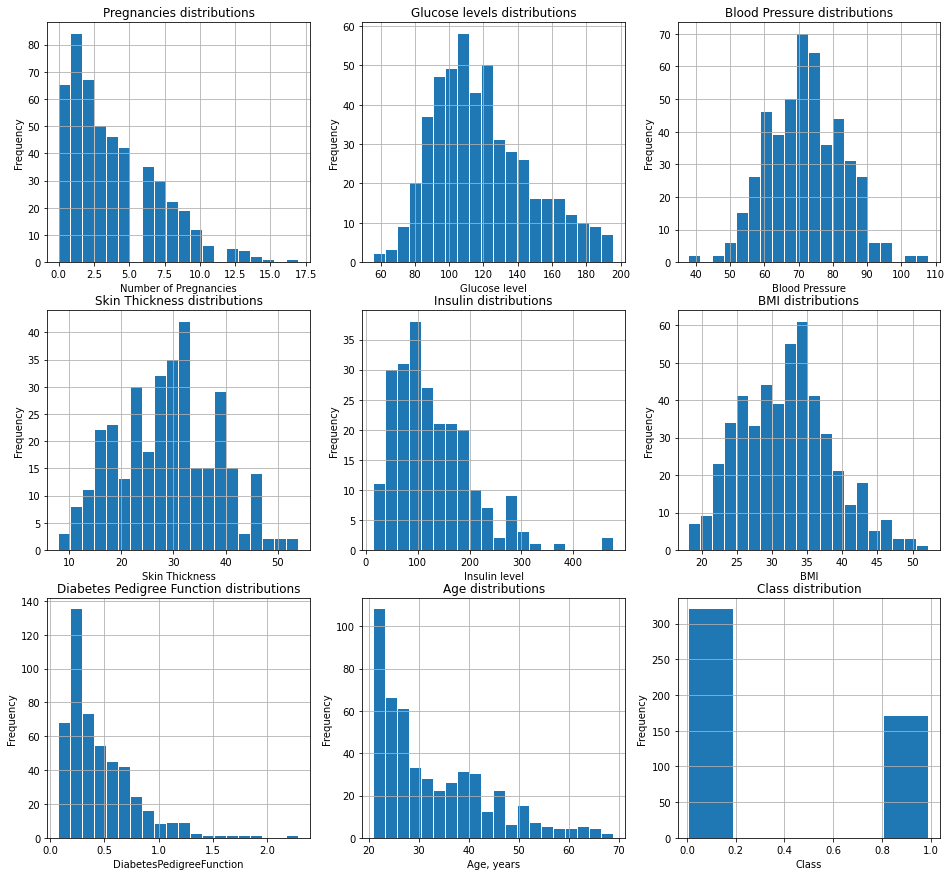

In [16]:
plt.figure(figsize=(16, 15))

ax1 = plt.subplot(331)
X_train["Pregnancies"].plot.hist(grid=True, bins=20, rwidth=0.9)
ax1.set_title('Pregnancies distributions')
ax1.set_xlabel('Number of Pregnancies')

ax2 = plt.subplot(332)
X_train["Glucose"].plot.hist(grid=True, bins=20, rwidth=0.9)
ax2.set_title('Glucose levels distributions')
ax2.set_xlabel('Glucose level')

ax3 = plt.subplot(333)
X_train["BloodPressure"].plot.hist(grid=True, bins=20, rwidth=0.9)
ax3.set_title('Blood Pressure distributions')
ax3.set_xlabel('Blood Pressure')

ax4 = plt.subplot(334)
X_train["SkinThickness"].plot.hist(grid=True, bins=20, rwidth=0.9)
ax4.set_title('Skin Thickness distributions')
ax4.set_xlabel('Skin Thickness')

ax5 = plt.subplot(335)
X_train["Insulin"].plot.hist(grid=True, bins=20, rwidth=0.9)
ax5.set_title('Insulin distributions')
ax5.set_xlabel('Insulin level')

ax6 = plt.subplot(336)
X_train["BMI"].plot.hist(grid=True, bins=20, rwidth=0.9)
ax6.set_title('BMI distributions')
ax6.set_xlabel('BMI')

ax7 = plt.subplot(337)
X_train["DiabetesPedigreeFunction"].plot.hist(grid=True, bins=20, rwidth=0.9)
ax7.set_title('Diabetes Pedigree Function distributions')
ax7.set_xlabel('DiabetesPedigreeFunction')

ax8 = plt.subplot(338)
X_train["Age"].plot.hist(grid=True, bins=20, rwidth=0.9)
ax8.set_title('Age distributions')
ax8.set_xlabel('Age, years')

ax9 = plt.subplot(339)
y_train.plot.hist(grid=True, bins=5, rwidth=0.9)
ax9.set_title('Class distribution')
ax9.set_xlabel('Class')

plt.show()

# Impute missing values and check Random Forest performance on imputed data

In [17]:
#Define classifier
classifier = RandomForestClassifier(random_state=0)

In [18]:
RF_results = pd.DataFrame(index = ['NaNs', 'Zero', 'Iterative', 'Exclude'],
                          columns = ['Mean accuracy', 'Std'])

## Method 1: leave NaNs

In [19]:
#Insert big negative value instead of NaNs - because CV function doesn't work on data with NaNs
X_nan = X_train.copy()
X_nan = X_nan.fillna(-999)

In [20]:
#Run 5-fold cross validation with Random forest classifier
cv_results = cross_validate(classifier, X_nan, y_train, cv=5, return_estimator = True)
RF_results.iloc[0] = [cv_results["test_score"].mean(), cv_results["test_score"].std()]

## Method 2: Zero imputation

In [21]:
#Imute missing values with zeros
X_zeros = X_train.copy()
X_zeros.fillna(0, inplace=True)

In [22]:
#Run 5-fold cross validation with Random forest classifier
cv_results = cross_validate(classifier, X_zeros, y_train, cv=5)
RF_results.iloc[1] = [cv_results["test_score"].mean(), cv_results["test_score"].std()]

## Method 3: Iterative Imputer

In [23]:
#Define Iterative Imputer
imp = IterativeImputer(max_iter = 10, random_state = 0, min_value = 5) #min value is due to biological meanigs

In [24]:
#Use iterative imputer to impute missing values
X_imp = X_train.copy()
X_imp = imp.fit_transform(X_imp)
X_imp = pd.DataFrame(X_imp)
X_imp.columns = X_train.columns

In [25]:
#Run 5-fold cross validation with Random forest classifier
cv_results = cross_validate(classifier, X_imp, y_train, cv=5)
RF_results.iloc[2] = [cv_results["test_score"].mean(), cv_results["test_score"].std()]

## Method 4: Exclude features

In [26]:
#Exclude columns with high number of missing values (SkinThickness and Insulin)
X_excl = X_train.copy()
X_excl.drop('SkinThickness', inplace=True, axis=1)
X_excl.drop('Insulin', inplace=True, axis=1)
#Impute NaN-like values for any missing values left
X_excl = X_excl.fillna(-999)

In [27]:
#Run 5-fold cross validation with Random forest classifier
cv_results = cross_validate(classifier, X_excl, y_train, cv=5)
RF_results.iloc[3] = [cv_results["test_score"].mean(), cv_results["test_score"].std()]

## Results 

In [28]:
RF_results

,Mean accuracy,Std
NaNs,0.792311,0.0158312
Zero,0.792311,0.0158312
Iterative,0.782107,0.0275698
Exclude,0.79431,0.0225861


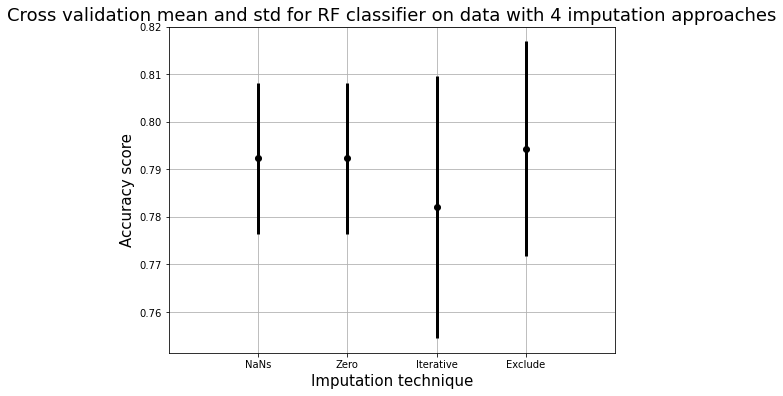

In [29]:
#PLot mean and std of cross validation results

fig = plt.figure(figsize = (8,6))
plt.errorbar(np.arange(4), RF_results['Mean accuracy'], RF_results['Std'], fmt='ok', lw=3)
plt.xlim(-1, 4)
plt.grid()
plt.title('Cross validation mean and std for RF classifier on data with 4 imputation approaches', size = 18)
plt.xlabel("Imputation technique", size = 15)
plt.ylabel("Accuracy score", size = 15)
plt.xticks(np.arange(4), RF_results.index) 
plt.show()

# Autoscaling

In [30]:
#Scale balanced data with NaNs values
scaler_nan = StandardScaler().fit(X_nan)
X_nan_scl = pd.DataFrame(scaler_nan.transform(X_nan))
X_nan_scl.columns = X_nan.columns

In [31]:
#Scale zero imputed balanced data
scaler_zeros = StandardScaler().fit(X_zeros)
X_zeros_scl = pd.DataFrame(scaler_zeros.transform(X_zeros))
X_zeros_scl.columns = X_zeros.columns

In [32]:
#Scale iterative imputed balanced data
scaler_imp = StandardScaler().fit(X_imp)
X_imp_scl = pd.DataFrame(scaler_imp.transform(X_imp))
X_imp_scl.columns = X_imp.columns

In [33]:
#Scale balanced data with excluded features
scaler_excl = StandardScaler().fit(X_excl)
X_excl_scl = pd.DataFrame(scaler_excl.transform(X_excl))
X_excl_scl.columns = X_excl.columns

# Bootstraping to balance the data

In [34]:
#Define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

## Oversample and check the performance

In [35]:
RF_results_bln = pd.DataFrame(index = ['NaNs', 'Zero', 'Iterative', 'Exclude'],
                          columns = ['Mean accuracy', 'Std'])

In [36]:
#Oversample data with missing values
X_nan_bln_scl, y_nan_bln = oversample.fit_resample(X_nan_scl, y_train)

#Check performance of cross-validation on balanced data
cv_results = cross_validate(classifier, X_nan_bln_scl, y_nan_bln, cv=5)
RF_results_bln.iloc[0] = [cv_results["test_score"].mean(), cv_results["test_score"].std()]

In [37]:
#Oversample zero imputed data
X_zeros_bln_scl, y_zeros_bln = oversample.fit_resample(X_zeros_scl, y_train)

#Check performance of cross-validation on balanced data
cv_results = cross_validate(classifier, X_zeros_bln_scl, y_zeros_bln, cv=5)
RF_results_bln.iloc[1] = [cv_results["test_score"].mean(), cv_results["test_score"].std()]

In [38]:
#Oversample iterative imputed data
X_imp_bln_scl, y_imp_bln = oversample.fit_resample(X_imp_scl, y_train)

#Check performance of cross-validation on balanced data
cv_results = cross_validate(classifier, X_imp_bln_scl, y_imp_bln, cv=5)
RF_results_bln.iloc[2] = [cv_results["test_score"].mean(), cv_results["test_score"].std()]

In [39]:
#Oversample data with excluded features
X_excl_bln_scl, y_excl_bln = oversample.fit_resample(X_excl_scl, y_train)

#Check performance of cross-validation on balanced data
cv_results = cross_validate(classifier, X_excl_bln_scl, y_excl_bln, cv=5)
RF_results_bln.iloc[3] = [cv_results["test_score"].mean(), cv_results["test_score"].std()]

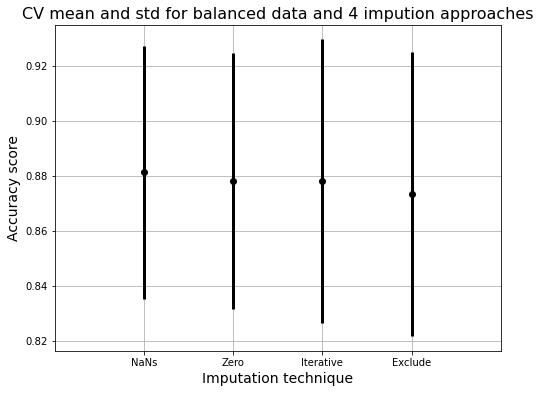

In [40]:
#Plot the results

fig = plt.figure(figsize = (8,6))
plt.errorbar(np.arange(4), RF_results_bln['Mean accuracy'], RF_results_bln['Std'], fmt='ok', lw=3)
plt.xlim(-1, 4)
plt.grid()
plt.xlabel("Imputation technique", size = 14)
plt.ylabel("Accuracy score", size = 14)
plt.xticks(np.arange(4), RF_results_bln.index)
plt.title('CV mean and std for balanced data and 4 impution approaches', size = 16)
plt.show()

# PCA 

In [41]:
#PCA with 5 components
pca = PCA(n_components=5)

In [42]:
#Calculate PCA scores for imputed data

#For NaNs data
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X_nan_bln_scl)
principalDf1 = pd.DataFrame(data = principalComponents)
principalDf1.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
#PCA variance explained
variance1 = pca.explained_variance_ratio_
#Create loadings matrix
loadings1 = pca.components_.T
#np.sqrt(pca.explained_variance_)
loading_matrix1 = pd.DataFrame(loadings1, columns = principalDf1.columns, index = X_train.columns)


#For Zero imputations
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X_zeros_bln_scl)
principalDf2 = pd.DataFrame(data = principalComponents)
principalDf2.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
#PCA variance explained
variance2 = pca.explained_variance_ratio_
#Create loadings matrix
loadings2 = pca.components_.T
#np.sqrt(pca.explained_variance_)
loading_matrix2 = pd.DataFrame(loadings2, columns = principalDf2.columns, index = X_train.columns)

#For Iterative imputations
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X_imp_bln_scl)
principalDf3 = pd.DataFrame(data = principalComponents)
principalDf3.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
#PCA variance explained
variance3 = pca.explained_variance_ratio_
#Create loadings matrix
loadings3 = pca.components_.T
#np.sqrt(pca.explained_variance_)
loading_matrix3 = pd.DataFrame(loadings3, columns = principalDf3.columns, index = X_train.columns)

#For excluded features
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X_excl_bln_scl)
principalDf4 = pd.DataFrame(data = principalComponents)
principalDf4.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
#PCA variance explained
variance4 = pca.explained_variance_ratio_
#Create loadings matrix
loadings4 = pca.components_.T
#np.sqrt(pca.explained_variance_)
loading_matrix4 = pd.DataFrame(loadings4, columns = principalDf4.columns, index = X_excl_bln_scl.columns)

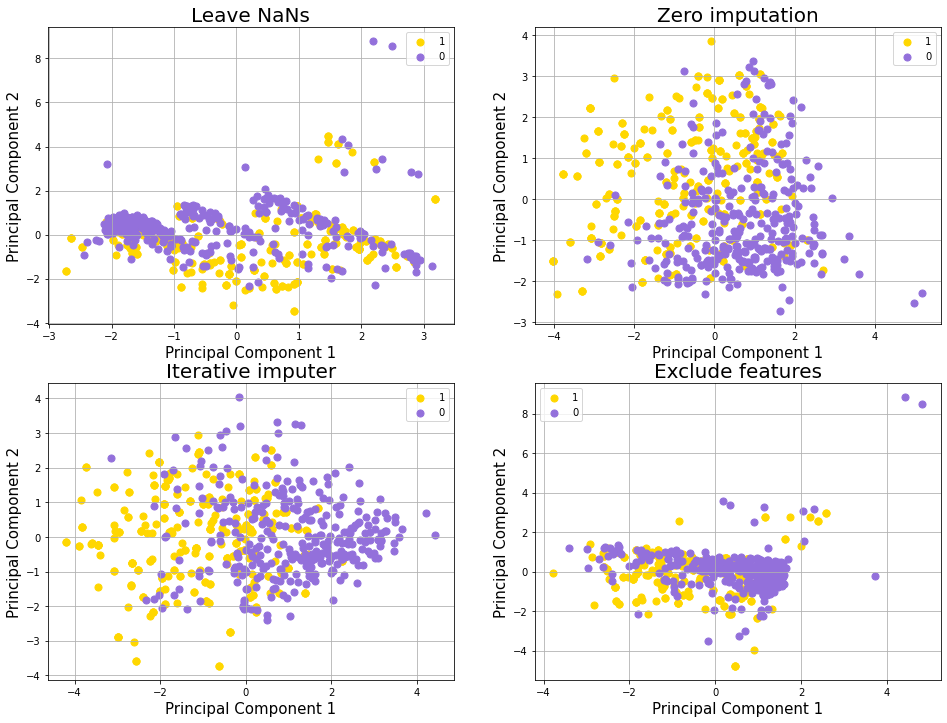

In [66]:
#Plot PC1 and PC2 with color coded diagnosis for imputed data

fig = plt.figure(figsize = (16,12))
#fig.suptitle('2 component PCA for imputed balanced scaled data', size = 20)

ax1 = fig.add_subplot(2,2,1)
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_title('Leave NaNs', fontsize = 20)
targets = y_nan_bln.dropna().unique().tolist()
colors = ['gold', 'mediumpurple']
for target, color in zip(targets,colors):
    indicesToKeep = pd.Series(y_nan_bln.tolist()) == target
    ax1.scatter(principalDf1.loc[indicesToKeep, 'PC1']
               , principalDf1.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax1.legend(targets)
ax1.grid()


ax2 = fig.add_subplot(2,2,2)
ax2.set_xlabel('Principal Component 1', fontsize = 15)
ax2.set_ylabel('Principal Component 2', fontsize = 15)
ax2.set_title('Zero imputation', fontsize = 20)
targets = y_zeros_bln.dropna().unique().tolist()
colors = ['gold', 'mediumpurple']
for target, color in zip(targets,colors):
    indicesToKeep = pd.Series(y_zeros_bln.tolist()) == target
    ax2.scatter(principalDf2.loc[indicesToKeep, 'PC1']
               , principalDf2.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax2.legend(targets)
ax2.grid()

ax3 = fig.add_subplot(2,2,3)
ax3.set_xlabel('Principal Component 1', fontsize = 15)
ax3.set_ylabel('Principal Component 2', fontsize = 15)
ax3.set_title('Iterative imputer', fontsize = 20)
targets = y_imp_bln.dropna().unique().tolist()
colors = ['gold', 'mediumpurple']
for target, color in zip(targets,colors):
    indicesToKeep = pd.Series(y_imp_bln.tolist()) == target
    ax3.scatter(principalDf3.loc[indicesToKeep, 'PC1']
               , principalDf3.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax3.legend(targets)
ax3.grid()

ax4 = fig.add_subplot(2,2,4)
ax4.set_xlabel('Principal Component 1', fontsize = 15)
ax4.set_ylabel('Principal Component 2', fontsize = 15)
ax4.set_title('Exclude features', fontsize = 20)
targets = y_excl_bln.dropna().unique().tolist()
colors = ['gold', 'mediumpurple']
for target, color in zip(targets,colors):
    indicesToKeep = pd.Series(y_excl_bln.tolist()) == target
    ax4.scatter(principalDf4.loc[indicesToKeep, 'PC1']
               , principalDf4.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax4.legend(targets)
ax4.grid()

plt.show()

In [44]:
#Print PCA variance ratio explained

print('PCA variance ratio explained for NaNs data:', variance1)
print('PCA variance ratio explained for Zeros imputed data:', variance2)
print('PCA variance ratio explained for Iterative imputed data:', variance3)
print('PCA variance ratio explained for Excluded features data:', variance4)

PCA variance ratio explained for NaNs data: [0.2693401  0.18961768 0.13916884 0.12713062 0.10377465]
PCA variance ratio explained for Zeros imputed data: [0.27547068 0.22894462 0.11831554 0.10986331 0.09478326]
PCA variance ratio explained for Iterative imputed data: [0.36070994 0.18607912 0.13464113 0.12356932 0.09385381]
PCA variance ratio explained for Excluded features data: [0.28939216 0.20795172 0.18168755 0.14057623 0.10421565]


# Loadings graph to evaluate features interdependencies 

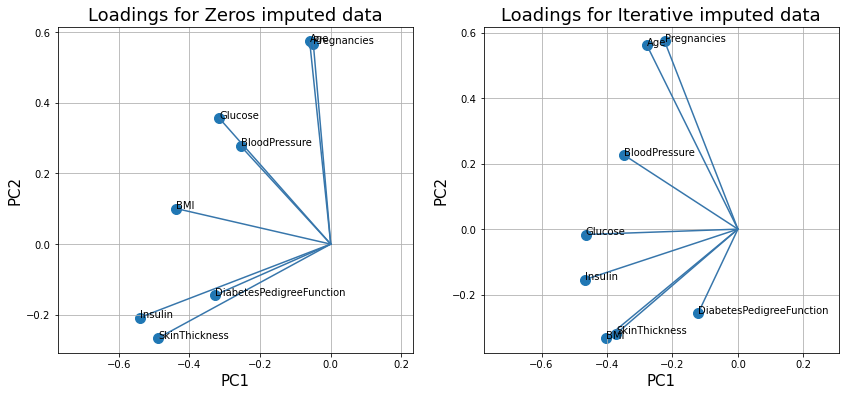

In [65]:
fig = plt.figure(figsize = (14,6))
#fig.suptitle('Loadings', size = 20)

ax2 = fig.add_subplot(1,2,1)
u = loading_matrix2.iloc[:, 0]
v = loading_matrix2.iloc[:, 1]
ax2.scatter(loading_matrix2.iloc[:, 0], loading_matrix2.iloc[:, 1], s = 100)
for i in range (0,8):
    ax2.annotate(loading_matrix2.index.tolist()[i], (u[i], v[i]))
    ax2.plot([0, u[i]], [0,v[i]], c = '#3776ab')

ax2.set_title('Loadings for Zeros imputed data', size = 18)
ax2.set_xlabel('PC1', size = 15)
ax2.set_ylabel('PC2', size = 15)
ax2.axis('equal')
ax2.grid()

ax3 = fig.add_subplot(1,2,2)
u = loading_matrix3.iloc[:, 0]
v = loading_matrix3.iloc[:, 1]
ax3.scatter(loading_matrix3.iloc[:, 0], loading_matrix3.iloc[:, 1], s = 100)
for i in range (0,8):
    ax3.annotate(loading_matrix3.index.tolist()[i], (u[i], v[i]))
    ax3.plot([0, u[i]], [0,v[i]], c = '#3776ab')

ax3.set_title('Loadings for Iterative imputed data', size = 18)
ax3.set_xlabel('PC1', size = 15)
ax3.set_ylabel('PC2', size = 15)
ax3.axis('equal')
ax3.grid()



plt.show()

# Random Forest classification on validation Data

## Iterative imputed data

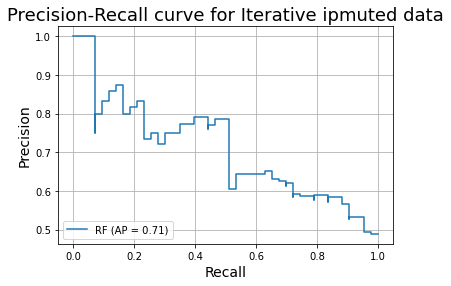

In [46]:
#Fit the model with imputed training data
classifier.fit(X_imp_bln_scl, y_imp_bln)

#Impute and scale validation data in the same way as training: Iterative imputer
X_val_imp = pd.DataFrame(imp.transform(X_val))
X_val_imp.columns = X_val.columns
X_val_imp_scl = pd.DataFrame(scaler_imp.transform(X_val_imp))
X_val_imp_scl.columns = X_val.columns

#Precision recall curve for Iterative imputed data
display = PrecisionRecallDisplay.from_estimator(classifier, X_val_imp_scl, y_val, name="RF")
display.ax_.set_title("Precision-Recall curve for Iterative ipmuted data", size = 18)
display.ax_.grid()
display.ax_.set_xlabel("Recall", size = 14)
display.ax_.set_ylabel("Precision", size = 14)
plt.show()

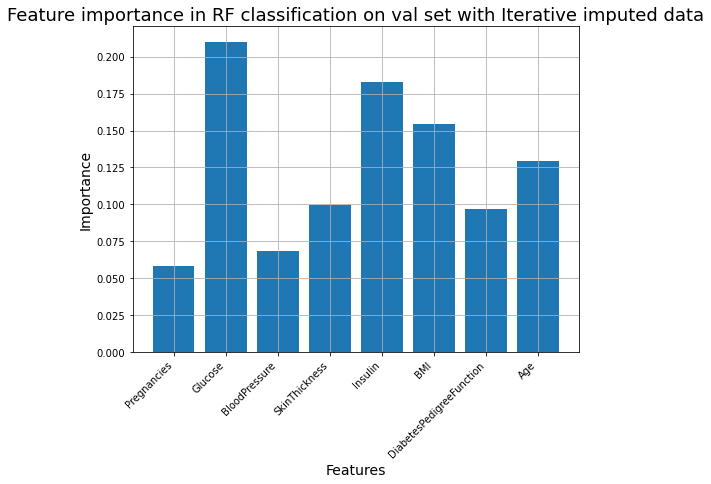

In [47]:
#Plot feature importance
importance = classifier.feature_importances_
    
fig = plt.figure(figsize = (8,6))    
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(ticks = [x for x in range(len(importance))], labels = X_imp_bln_scl.columns.tolist(), rotation=45, ha="right")
plt.grid()
plt.xlabel("Features", size = 14)
plt.ylabel("Importance", size = 14)
plt.title("Feature importance in RF classification on val set with Iterative imputed data", size = 18)
plt.show()

## zero imputed data

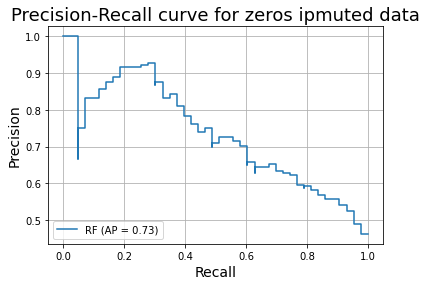

In [48]:
# Fit the model with zero imputed training data
classifier.fit(X_zeros_bln_scl, y_zeros_bln)

#Impute and scale validation data in the same way as training: Zero imputation
X_val_zeros = X_val.copy()
X_val_zeros.fillna(0, inplace=True)
X_val_zeros_scl = pd.DataFrame(scaler_zeros.transform(X_val_zeros))
X_val_zeros_scl.columns = X_val.columns

#Precision recall curve for Iterative imputed data
display = PrecisionRecallDisplay.from_estimator(classifier, X_val_zeros_scl, y_val, name="RF")
display.ax_.set_title("Precision-Recall curve for zeros ipmuted data", size = 18)
display.ax_.grid()
display.ax_.set_xlabel("Recall", size = 14)
display.ax_.set_ylabel("Precision", size = 14)
plt.show()

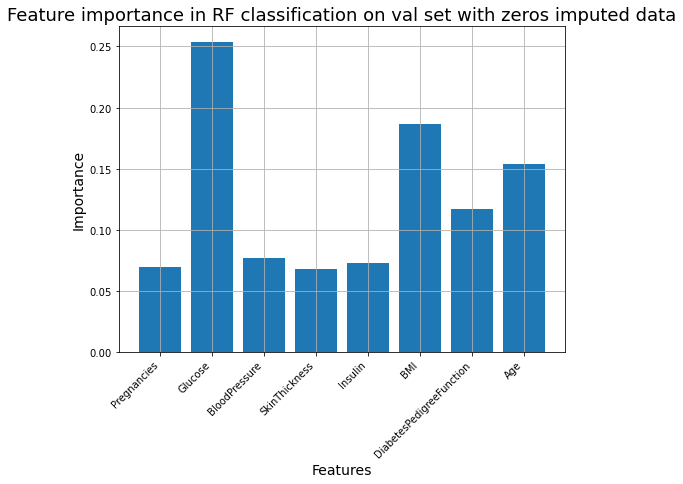

In [49]:
#Plot feature importance
importance = classifier.feature_importances_
    
fig = plt.figure(figsize = (8,6))    
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(ticks = [x for x in range(len(importance))], labels = X_zeros_bln_scl.columns.tolist(), rotation=45, ha="right")
plt.grid()
plt.xlabel("Features", size = 14)
plt.ylabel("Importance", size = 14)
plt.title("Feature importance in RF classification on val set with zeros imputed data", size = 18)
plt.show()

# Optimizing parameters 

## Iterative imputed data

In [50]:
#Cross-validation Precision-Recall and Accuracy mean scores with std for varying min_leaf and min_split
Results_param = pd.DataFrame(columns = ['Min leaf', 'Min split', 'Mean Recall score', 'Recall Std', 'Mean Acc', 'Acc Std'])

for minleaf in (1, 2, 5, 10, 15, 20):
    for minsplit in (2, 5, 10, 15, 20):
        model = RandomForestClassifier(min_samples_leaf = minleaf, min_samples_split= minsplit)
        scores = cross_validate(model, X_imp_bln_scl, y_imp_bln, scoring=make_scorer(precision_score), cv=5)
        scoresAcc = cross_validate(model, X_imp_bln_scl, y_imp_bln, cv=5)
        Results_param = Results_param.append(pd.DataFrame([[minleaf, minsplit, scores['test_score'].mean(),
                                                            scores['test_score'].std(), scoresAcc['test_score'].mean(),
                                                            scoresAcc['test_score'].std()]],
                                                          columns = ['Min leaf', 'Min split',
                                                                     'Mean Recall score', 'Recall Std', 'Mean Acc', 'Acc Std']), ignore_index = True)

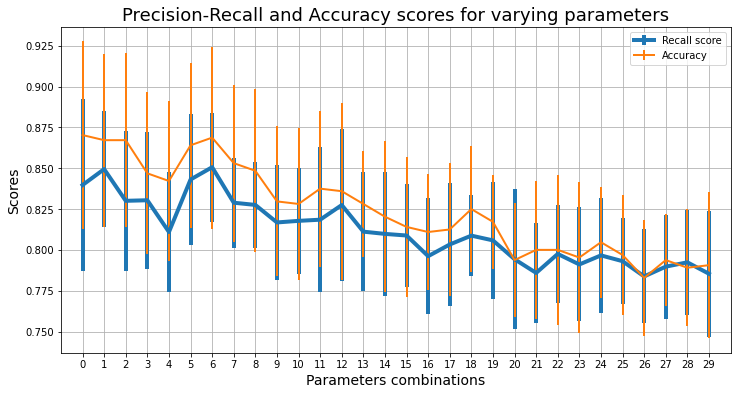

In [51]:
#Plot recall and accuracy scores
fig = plt.figure(figsize = (12, 6))
plt.errorbar(np.arange(30), Results_param['Mean Recall score'], Results_param['Recall Std'], lw=4)
plt.errorbar(np.arange(30), Results_param['Mean Acc'], Results_param['Acc Std'], lw=2)
plt.legend(['Recall score', 'Accuracy'])
plt.xlim(-1, 30)
plt.grid()
plt.xlabel("Parameters combinations", size = 14)
plt.ylabel("Scores", size = 14)
plt.xticks(np.arange(30))#, RF_results_bln.index)
plt.title('Precision-Recall and Accuracy scores for varying parameters', size = 18)
plt.show()

## Zero imputed data

In [52]:
#Cross-validation Precision-Recall and Accuracy mean scores with std for varying min_leaf and min_split
Results_param = pd.DataFrame(columns = ['Min leaf', 'Min split', 'Mean Recall score', 'Recall Std', 'Mean Acc', 'Acc Std'])

for minleaf in (1, 2, 5, 10, 15, 20):
    for minsplit in (2, 5, 10, 15, 20):
        model = RandomForestClassifier(min_samples_leaf = minleaf, min_samples_split= minsplit)
        scores = cross_validate(model, X_zeros_bln_scl, y_zeros_bln, scoring=make_scorer(precision_score), cv=5)
        scoresAcc = cross_validate(model, X_zeros_bln_scl, y_zeros_bln, cv=5)
        Results_param = Results_param.append(pd.DataFrame([[minleaf, minsplit, scores['test_score'].mean(),
                                                            scores['test_score'].std(), scoresAcc['test_score'].mean(),
                                                            scoresAcc['test_score'].std()]],
                                                          columns = ['Min leaf', 'Min split',
                                                                     'Mean Recall score', 'Recall Std', 'Mean Acc', 'Acc Std']), ignore_index = True)

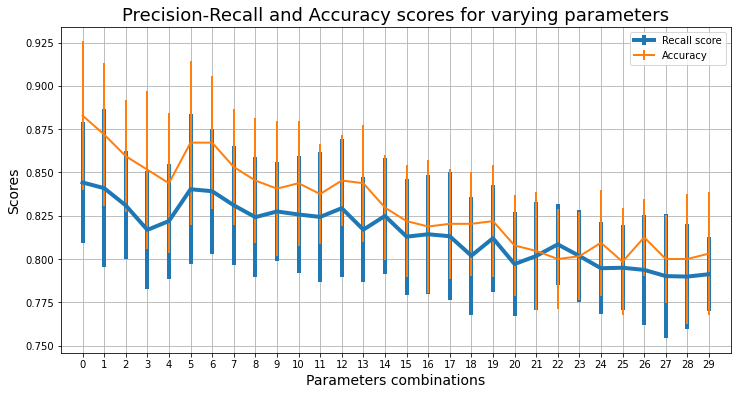

In [53]:
#Plot recall and accuracy scores
fig = plt.figure(figsize = (12, 6))
plt.errorbar(np.arange(30), Results_param['Mean Recall score'], Results_param['Recall Std'], lw=4)
plt.errorbar(np.arange(30), Results_param['Mean Acc'], Results_param['Acc Std'], lw=2)
plt.legend(['Recall score', 'Accuracy'])
plt.xlim(-1, 30)
plt.grid()
plt.xlabel("Parameters combinations", size = 14)
plt.ylabel("Scores", size = 14)
plt.xticks(np.arange(30))#, RF_results_bln.index)
plt.title('Precision-Recall and Accuracy scores for varying parameters', size = 18)
plt.show()

# Final evaluation on the test set

In [54]:
#Merge training and validation data into one training set and impute missing values
X_train_final = X_train.append(X_val)
y_train_final = y_train.append(y_val)

In [55]:
#Check if data is balanced
print(sum(y_train_final == 1)) 
print(sum(y_train_final == 0)) #=> balancing is needed

214
400


## Iterative imputed data

In [56]:
#Define Iterative Imputer
imp_train = IterativeImputer(max_iter = 10, random_state = 0, min_value = 5)

#Use iterative imputer to impute missing values
X_train_imp = X_train_final.copy()
X_train_imp = imp_train.fit_transform(X_train_imp)
X_train_imp = pd.DataFrame(X_train_imp)
X_train_imp.columns = X_train.columns

In [57]:
#Autoscale training data
scaler_train_imp = StandardScaler().fit(X_train_imp)
X_train_imp_scl = pd.DataFrame(scaler_train_imp.transform(X_train_imp))
X_train_imp_scl.columns = X_train_imp.columns

#Oversample the training data
X_train_imp_scl_bln, y_train_imp_bln = oversample.fit_resample(X_train_imp_scl, y_train_final)

In [58]:
#Impute and scale test data in the same way as training: Iterative imputer
X_test_imp = pd.DataFrame(imp_train.transform(X_test))
X_test_imp.columns = X_test.columns
X_test_imp_scl = pd.DataFrame(scaler_train_imp.transform(X_test_imp))
X_test_imp_scl.columns = X_test.columns

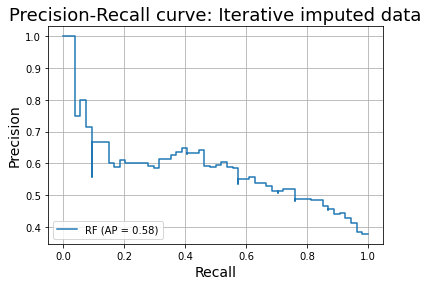

Prediction accuracy: 66%


In [75]:
#Fit RF classifier with complete training set
classifier.fit(X_train_imp_scl_bln, y_train_imp_bln)

#Precision recall curve for Iterative imputed data
display = PrecisionRecallDisplay.from_estimator(classifier, X_test_imp_scl, y_test, name="RF")
display.ax_.set_title("Precision-Recall curve: Iterative imputed data", size = 18)
display.ax_.grid()
display.ax_.set_xlabel("Recall", size = 14)
display.ax_.set_ylabel("Precision", size = 14)
plt.show()

#Prediction accuracy
print('Prediction accuracy: {:.0%}'.format(classifier.score(X_test_imp_scl, y_test)))

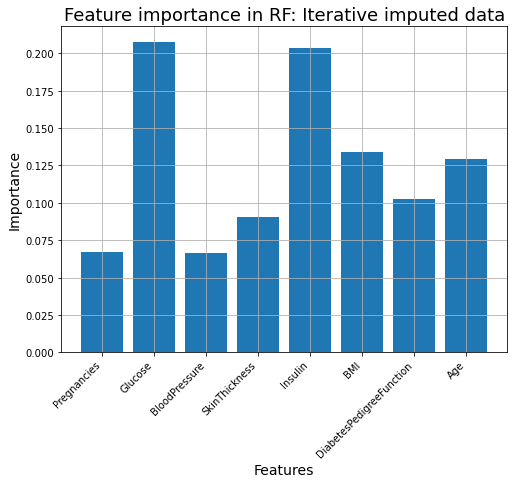

In [76]:
#Plot feature importance
importance = classifier.feature_importances_
    
fig = plt.figure(figsize = (8,6))    
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(ticks = [x for x in range(len(importance))], labels = X_imp_bln_scl.columns.tolist(), rotation=45, ha="right")
plt.grid()
plt.xlabel("Features", size = 14)
plt.ylabel("Importance", size = 14)
plt.title("Feature importance in RF: Iterative imputed data", size = 18)
plt.show()

## Zero imputed data

In [77]:
#Impute zeros to final training data
X_train_zeros = X_train_final.copy()
X_train_zeros.fillna(0, inplace=True)

#Autoscale training data
scaler_train_zeros = StandardScaler().fit(X_train_zeros)
X_train_zeros_scl = pd.DataFrame(scaler_train_zeros.transform(X_train_zeros))
X_train_zeros_scl.columns = X_train_zeros.columns

#Oversample the training data
X_train_zeros_scl_bln, y_train_zeros_bln = oversample.fit_resample(X_train_zeros_scl, y_train_final)

In [78]:
#Impute and scale test data in the same way as training: Zeros imputer
X_test_zeros = X_test.copy()
X_test_zeros.fillna(0, inplace=True)
X_test_zeros_scl = pd.DataFrame(scaler_train_zeros.transform(X_test_zeros))
X_test_zeros_scl.columns = X_test.columns

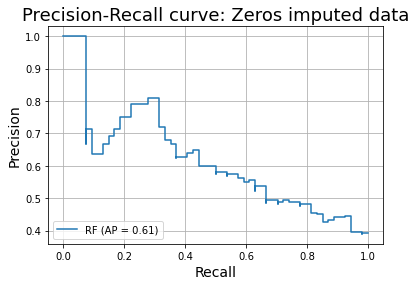

Prediction accuracy: 68%


In [79]:
#Fit RF classifier with complete training set
classifier.fit(X_train_zeros_scl_bln, y_train_zeros_bln)

#Precision recall curve for Iterative imputed data
display = PrecisionRecallDisplay.from_estimator(classifier, X_test_zeros_scl, y_test, name="RF")
display.ax_.set_title("Precision-Recall curve: Zeros imputed data", size = 18)
display.ax_.grid()
display.ax_.set_xlabel("Recall", size = 14)
display.ax_.set_ylabel("Precision", size = 14)
plt.show()

#Prediction accuracy
print('Prediction accuracy: {:.0%}'.format(classifier.score(X_test_imp_scl, y_test)))

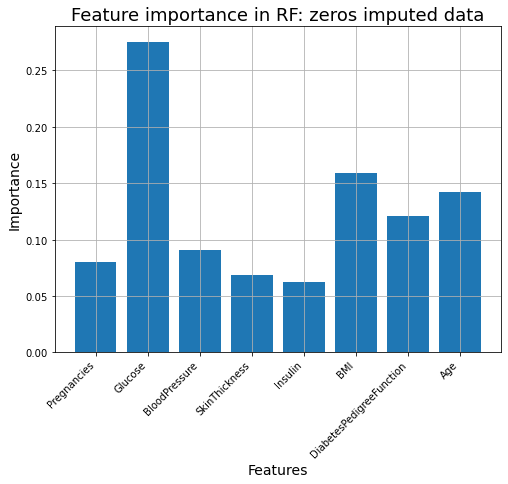

In [80]:
#Plot feature importance
importance = classifier.feature_importances_
    
fig = plt.figure(figsize = (8,6))    
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(ticks = [x for x in range(len(importance))], labels = X_imp_bln_scl.columns.tolist(), rotation=45, ha="right")
plt.grid()
plt.xlabel("Features", size = 14)
plt.ylabel("Importance", size = 14)
plt.title("Feature importance in RF: zeros imputed data", size = 18)
plt.show()